In [1]:
# For now we use the embeddings of what a group member said to predict/his her gratitude rating for a session
# One improvement could be to compute the average embedding of what other group members said during the session
# and concatenate this vector with the vector representing the individual's utterances.  A classifier trained on
# individual features + group features should perform a bit better with enough data

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gc
import multiprocessing
from datasets import load_from_disk, Dataset, DatasetDict  
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error

from embed import mean_pool_sentence_embedding

In [3]:
max_seq_len = 512
data_path = 'transcript_data.xlsx'
ids_path = 'ids.xlsx'
ratings_path = 'gratitude.xlsx'
lm_path = 'roberta-base'

# Set the batch size for the embedding model
batch_size = 16

# Select whether to compute new embeddings for the data or use precomputed embeddings
# On the first run, embeddings must be computed.  On subsequent runs, embeddings can be loaded from disk.
embed = True

# Set the device to GPU if you have one, MPS if you are on a Mac with an M1/M2 chip, otherwise CPU
device = "cuda:0"

seed = 44
k = 5


# COMPARE BERT-BASED Features to TFIDF

In [4]:
torch.__version__

'1.8.1+cu101'

In [5]:
rating_df = pd.read_excel(ratings_path)

In [7]:
id_df = pd.read_excel(ids_path)

In [9]:
digit_rating_df = pd.merge(
    rating_df[['DigitID', 'Group', 'Session', 'Gratitude_Members']],
    id_df,
    how='inner',
    left_on='DigitID',
    right_on='Digit ID'
).drop_duplicates().drop('Group_y', axis=1).rename(columns={'Group_x': 'Group'})

In [11]:
df = pd.read_excel(data_path)

In [13]:
df = pd.merge(
    df,
    digit_rating_df,
    how='inner',
    on=['Member ID', 'Group', 'Session']
)

In [15]:
grouped_df = df.groupby(['Group', 'Session', 'Member ID']).agg({'Gratitude_Members': 'max'}).reset_index()

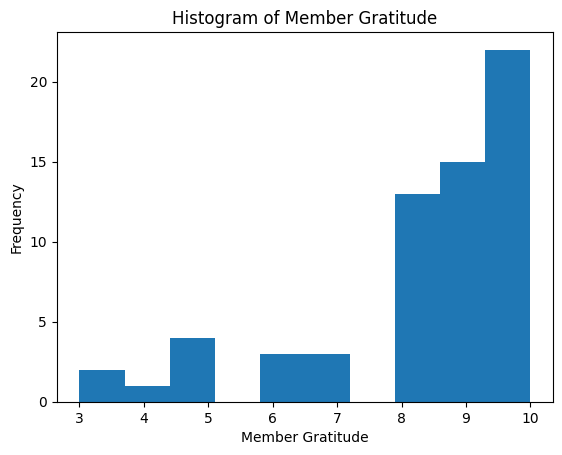

In [17]:
plt.hist(grouped_df['Gratitude_Members'], bins=10)
plt.xlabel('Member Gratitude')
plt.ylabel('Frequency')
plt.title("Histogram of Member Gratitude")
plt.show()

In [18]:
tokenizer = AutoTokenizer.from_pretrained(lm_path)

In [19]:
def plot_token_len_distribution(dataset):

    plt.hist([len(ids) for ids in dataset['input_ids']], bins=50)
    plt.ylabel("Frequency")
    plt.xlabel("Tokens per Utterance")
    plt.title("Distribution of Tokens per Utterance")
    plt.show()

In [20]:
def tokenize_text(record, tokenizer, truncate_to):
    
    return {
        'input_ids': tokenizer(
            record['text'],
            padding=False,
            truncation=True,
            max_length=truncate_to
        )['input_ids']
    }

In [21]:
def tokenize_plot(dataset, tokenizer, truncate_to, batch_size=512, proc_div=2):
    
    num_proc = int(multiprocessing.cpu_count() / proc_div)
    print(f"Tokenizing with {num_proc} CPU processes...")
    
    dataset = dataset.map(
        tokenize_text,
        batched=True,
        batch_size=batch_size,
        fn_kwargs={
            "tokenizer": tokenizer,
            "truncate_to": truncate_to
        },
        num_proc=num_proc
    )
    
    plot_token_len_distribution(dataset)
    dataset.remove_columns('input_ids')
    gc.collect()

Tokenizing with 4 CPU processes...


Map (num_proc=4):   0%|          | 0/433 [00:00<?, ? examples/s]

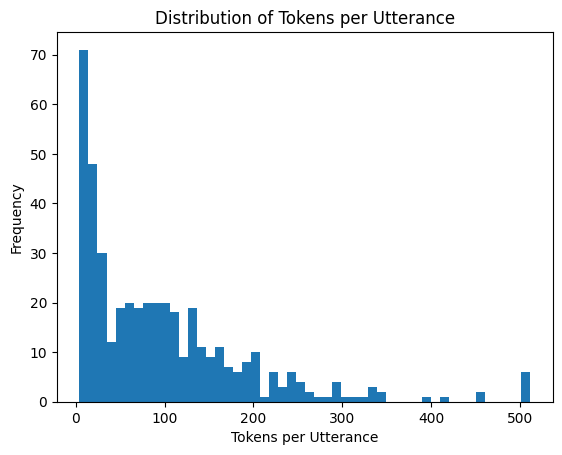

In [22]:
text_df = df.rename(columns={'Utterance': 'text'})[['Group', 'Session', 'Member ID', 'text', 'Gratitude_Members']]
tokenize_plot(Dataset.from_pandas(text_df), tokenizer, truncate_to=max_seq_len)

In [24]:
lm = AutoModel.from_pretrained(lm_path)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# Ensure the model is in evaluation mode and on the correct device
lm = lm.to(device)
lm.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [26]:
# Create or load embeddings
if embed:

    embeddings = mean_pool_sentence_embedding(
        text_df['text'].to_list(),
        tokenizer,
        lm,
        batch_size,
        device,
        max_seq_len
    )
    np.save("embeddings.npy", embeddings)

else:

    embeddings = np.load("embeddings.npy", allow_pickle=True)

In [28]:
text_df['embedding'] = embeddings.tolist()

In [29]:
grat_df = text_df.groupby(['Group', 'Session', 'Member ID']).agg({'Gratitude_Members': 'max'}).reset_index()

In [30]:
emb_df = text_df.groupby(['Group', 'Session', 'Member ID'])['embedding'].apply(lambda s: np.array(list(s)).mean(axis=0)).reset_index()

In [31]:
# def mean_without_current(s):
#     n = len(s)
#     total_sum = np.array(list(s)).sum(axis=0)
#     mean_without_current = (total_sum - np.array(list(s))) / (n-1)
#     return pd.Series(mean_without_current.tolist())

In [32]:
#text_df['non_mem_emb'] = text_df.groupby(['Group', 'Session'])['embedding'].transform(mean_without_current)

In [33]:
#non_mem_emb_df = text_df[['Group', 'Session', 'Member ID', 'non_mem_emb']].copy()

In [34]:
#non_mem_emb_df

In [35]:
all_utterance_df = text_df.groupby(['Group', 'Session', 'Member ID'])['text'].apply(lambda s: ' '.join(list(s))).reset_index()

In [36]:
comb_df = pd.merge(
    pd.merge(grat_df, emb_df, how='inner', on=['Group', 'Session', 'Member ID']),
    all_utterance_df,
    how='inner',
    on=['Group', 'Session', 'Member ID']
)

In [37]:
# Code to follow assumes the order of X_emb and X_text are the same but with different feature representations
# That is, the same indices should contain the same data samples
X_emb = comb_df['embedding'].tolist()
X_text = comb_df['text'].values
y = comb_df['Gratitude_Members'].values

In [38]:
len(X_emb), len(X_text), len(y)

(63, 63, 63)

In [39]:
lr = LinearRegression()
scores = cross_val_score(lr, X_emb, y, cv=k, scoring='neg_mean_absolute_error')

In [40]:
avg_mae = np.mean(scores) * -1
std_mae = np.std(scores)
round(avg_mae, 3), round(std_mae, 3)

(1.806, 0.602)

In [41]:
mean_model_maes = []
count_lr_maes = []
count_ridge_maes = []
roberta_ridge_maes = []

kfold = KFold(n_splits=k, shuffle=False)
for train, test in kfold.split(X_text, y):
    
    # Fit count vectorizer LR
    count_vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.9)
    count_standard_scaler = StandardScaler()
    X_train = count_standard_scaler.fit_transform(count_vectorizer.fit_transform(X_text[train]).toarray())
    X_test = count_standard_scaler.transform(count_vectorizer.transform(X_text[test]).toarray())                       
    count_lr = LinearRegression()
    count_lr.fit(X_train, y[train])
    count_lr_maes.append(mean_absolute_error(y_true=y[test], y_pred=count_lr.predict(X_test)))
    
    # Fit count vectorizer Ridge
    count_vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.9)
    count_standard_scaler = StandardScaler()
    X_train = count_standard_scaler.fit_transform(count_vectorizer.fit_transform(X_text[train]).toarray())
    X_test = count_standard_scaler.transform(count_vectorizer.transform(X_text[test]).toarray())                       
    count_ridge = Ridge(alpha=1000)
    count_ridge.fit(X_train, y[train])
    count_ridge_maes.append(mean_absolute_error(y_true=y[test], y_pred=count_ridge.predict(X_test)))
    
    # Fit RoBERTa LR
    roberta_standard_scaler = StandardScaler()
    X_train = roberta_standard_scaler.fit_transform(np.array(X_emb)[train])
    X_test = roberta_standard_scaler.transform(np.array(X_emb)[test])                      
    roberta_ridge = Ridge(alpha=1000000)
    roberta_ridge.fit(X_train, y[train])
    roberta_ridge_maes.append(mean_absolute_error(y_true=y[test], y_pred=roberta_ridge.predict(X_test)))
    
    # Fit mean model
    mean_model_maes.append(mean_absolute_error(y_true=y[test], y_pred=[np.mean(y[train])] * len(y[test])))

In [42]:
results_df = pd.DataFrame(
    {'Mean Model': mean_model_maes,
     'Count Vectorizer LR': count_lr_maes,
     'Count Vectorizer Ridge': count_ridge_maes,
     'RoBERTa Ridge': roberta_ridge_maes
    })

In [43]:
results_df

,Mean Model,Count Vectorizer LR,Count Vectorizer Ridge,RoBERTa Ridge
0,1.087692,0.925038,0.959863,1.087592
1,1.960000,1.902513,1.913313,1.960296
2,1.733846,1.852023,1.780553,1.734747
3,0.983660,0.937285,0.936227,0.983301
4,1.408497,1.592642,1.497863,1.409160


In [44]:
round(results_df['Mean Model'].mean(), 3), round(results_df['Mean Model'].std(), 3)

(1.435, 0.415)

In [45]:
round(results_df['Count Vectorizer LR'].mean(), 3), round(results_df['Count Vectorizer LR'].std(), 3)

(1.442, 0.481)

In [46]:
round(results_df['Count Vectorizer Ridge'].mean(), 3), round(results_df['Count Vectorizer Ridge'].std(), 3)

(1.418, 0.454)

In [47]:
round(results_df['RoBERTa Ridge'].mean(), 3), round(results_df['RoBERTa Ridge'].std(), 3)

(1.435, 0.416)

In [48]:
# Try fitting to all data and looking at coefs

In [49]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.9)
count_standard_scaler = StandardScaler()
X_train = count_vectorizer.fit_transform(X_text).toarray()
X_train = count_standard_scaler.fit_transform(X_train)

In [50]:
clfs = []
num_bootstrap = 100
for i in range(num_bootstrap):
    boot_indices = np.arange(len(y))
    boot_sample_indices = np.random.choice(
        boot_indices, size=len(boot_indices), replace=True
    )
    
    boot_train_features = X_train[boot_sample_indices]
    boot_y_train = y[boot_sample_indices]
    
    lr = Ridge(alpha=1000, fit_intercept=True)
    lr = lr.fit(boot_train_features, boot_y_train)
    clfs.append(lr)

In [51]:

def plot_coefs(clfs, features, top_n=10, x_size=12, y_size=12):
    """
    Plot top N coefficients by absolute value in descending order
    """

    all_coefs = []
    for clf in clfs:
        features_and_intercept = np.concatenate((features, ["intercept"]), axis=0)
        coefficients = np.concatenate((clf.coef_, np.array([clf.intercept_])), axis=0)
        all_coefs.append(coefficients)

    coef_matrix = np.vstack(all_coefs)
    mean_coefficients = np.mean(coef_matrix, axis=0)
    std_coefficients = np.std(coef_matrix, axis=0)

    indices = (-np.abs(mean_coefficients)).argsort()
    top_coefs_mean = mean_coefficients[indices][0:top_n].tolist()
    top_coefs_std = std_coefficients[indices][0:top_n].tolist()
    top_feats = features_and_intercept[indices][0:top_n].tolist()
    
    for i, (coef, feat) in enumerate(zip(top_coefs_mean, top_feats)):
        print(f"{i+1}, {feat}, {round(coef, 3)}, {round(np.exp(coef), 3)}")

    top_coefs_mean.reverse()
    top_coefs_std.reverse()
    top_feats.reverse()

    plt.clf()
    plt.figure(figsize=(x_size, y_size))

    plt.title("Logistic Regression Coefficients")
    plt.barh(
        range(len(top_coefs_mean)),
        top_coefs_mean,
        xerr=1.96 * np.array(top_coefs_std),
        color="navy",
        align="center",
    )
    plt.yticks(range(len(top_coefs_mean)), top_feats)
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.axvline(x=0, color="red", linestyle="--")

    plt.show()

In [52]:
clfs[0].coef_

array([ 0.00073142, -0.00462438, -0.00892629, ...,  0.00104523,
       -0.00012561, -0.00215498])

In [53]:
clfs[0].intercept_

8.542151403461519

In [ ]:
# plot_coefs(
#     clfs, count_vectorizer.get_feature_names_out(), top_n=40, x_size=12, y_size=12
# )